In [2]:
import cv2, os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import torch
from torchvision import datasets
import torchvision.utils as tv_utils
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, DataLoader
workers = 0 if os.name == 'nt' else 4

In [3]:
MIN_FACE_CONFIDENCE = 0.95
OUTPUT_FOLDER = 'photos_friends_actors'

In [24]:
names_dict={'Chandler':0, 'Joey':1, 'Monica':2, 'Phoebe':3, 'Rachel':4, 'Ross':5}

In [25]:
name_list=list(names_dict.keys())

In [4]:
from facenet_pytorch import MTCNN, InceptionResnetV1
# read https://github.com/timesler/facenet-pytorch/blob/master/examples/infer.ipynb

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

Running on device: cpu


In [5]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, prewhiten=True, keep_all=True, 
    device=device
)

In [6]:
def collate_fn(x):
    return x[0]

In [7]:
dataset=datasets.ImageFolder(OUTPUT_FOLDER)
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [8]:
aligned = []
names = []
#ind_img=0
#ind_face=0
for x,y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        for face,p in  zip(x_aligned,prob):
            print(f'Face detected with probability: {p:.6f}')
            if p>=MIN_FACE_CONFIDENCE:
                aligned.append(face)
                names.append(dataset.idx_to_class[y])

Face detected with probability: 0.999998
Face detected with probability: 0.999758
Face detected with probability: 0.999740
Face detected with probability: 0.999960
Face detected with probability: 0.999613
Face detected with probability: 0.999999
Face detected with probability: 0.999715
Face detected with probability: 0.999980
Face detected with probability: 0.999989
Face detected with probability: 0.999945
Face detected with probability: 0.999883
Face detected with probability: 0.999998
Face detected with probability: 0.999999
Face detected with probability: 0.999882
Face detected with probability: 0.999988
Face detected with probability: 0.999650
Face detected with probability: 0.999971
Face detected with probability: 0.999034
Face detected with probability: 0.999707
Face detected with probability: 0.999911
Face detected with probability: 0.893902
Face detected with probability: 0.999981
Face detected with probability: 0.999773
Face detected with probability: 0.999643
Face detected wi

In [9]:
aligned[0].shape

torch.Size([3, 160, 160])

In [10]:
X =torch.stack(aligned).to(device)
batch_size = 32
embeddings = [resnet(X[k:k+batch_size]).detach().cpu() for k in range(0, X.shape[0], batch_size)]
embeddings = torch.cat(embeddings, dim = 0)


In [11]:
X_vectors=embeddings.data.numpy()

In [13]:
y=np.array([names_dict[name] for name in names])

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing import Normalizer

In [15]:
X_train, X_test, y_train, y_test=train_test_split(X_vectors,y,test_size=0.30, stratify=y)

In [16]:
# https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/

# normalize input vectors
in_encoder = Normalizer(norm='l2')
X_train = in_encoder.transform(X_train)
X_test = in_encoder.transform(X_test)

In [23]:
from joblib import dump, load
def model_test(X_train,y_train,X_test,y_test, C=1, kernel='linear', gamma='auto', decision_function_shape='ovr'):
    model=svm.SVC(C=C, kernel=kernel, gamma=gamma, decision_function_shape=decision_function_shape)
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    dump(model, 'data\svm_model.joblib') 
    return y_pred

In [32]:
def show_metrics(y_test, y_pred):
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Precision:",metrics.precision_score(y_test, y_pred,average=None))
    print("Recall:",metrics.recall_score(y_test, y_pred,average=None))
    c_matrix = pd.DataFrame(metrics.confusion_matrix(y_test,y_pred), columns=name_list, index=name_list)

    ax=sns.heatmap(c_matrix, annot=True)
    plt.xlabel('Predicted Name', fontsize=14)
    plt.ylabel('Actual Name', fontsize=14)
    ax.set_xticklabels(name_list,fontsize=12, rotation=45)
    plt.savefig('SVM_confusion matrix.svg', format='svg')
    plt.show()


In [28]:
y_pred=model_test(X_train,y_train,X_test,y_test, decision_function_shape='ovo')

Accuracy: 1.0
Precision: [1. 1. 1. 1. 1. 1.]
Recall: [1. 1. 1. 1. 1. 1.]


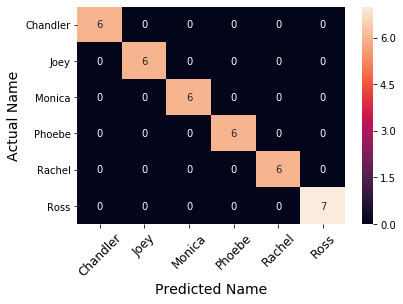

In [33]:
show_metrics(y_test,y_pred)